In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn import preprocessing
import os
%matplotlib inline

In [2]:
# load the data
all_slices = np.load(os.path.join("data", "all_slices.npy"))
all_labels = np.load(os.path.join("data", "all_labels.npy"))

normal_slices_0 = np.load(os.path.join("data", "image_batch_0.npy"))
normal_labels_0 = np.load(os.path.join("data", "label_batch_0.npy"))

normal_slices_1 = np.load(os.path.join("data", "image_batch_1.npy"))
normal_labels_1 = np.load(os.path.join("data", "label_batch_1.npy"))

normal_slices_2 = np.load(os.path.join("data", "image_batch_2.npy"))
normal_labels_2 = np.load(os.path.join("data", "label_batch_2.npy"))

normal_slices_3 = np.load(os.path.join("data", "image_batch_3.npy"))
normal_labels_3 = np.load(os.path.join("data", "label_batch_3.npy"))

normal_slices_4 = np.load(os.path.join("data", "image_batch_4.npy"))
normal_labels_4 = np.load(os.path.join("data", "label_batch_4.npy"))

# concatenate all the data and shuffle it
all_images = np.concatenate([all_slices, normal_slices_0, normal_slices_1, normal_slices_2, normal_slices_3, normal_slices_4], axis=0)
all_labels = np.concatenate([all_labels, normal_labels_0, normal_labels_1, normal_labels_2, normal_labels_3, normal_labels_4], axis=0)

print("All images:", all_images.shape)
print("All labels:", all_labels.shape)

All images: (21278, 299, 299, 1)
All labels: (21278,)


In [4]:
# shuffle the data
images, labels = shuffle(all_images, all_labels, random_state=3455)

In [26]:
# encode the labels
le = preprocessing.LabelEncoder()
le.fit(labels)
# we want normal to be 0, so we'll do some transformations here
labels_enc = le.transform(labels) + 1
labels_enc[labels_enc == 5] = 0

# make the classes be in the same order as the labels
classes = le.classes_
classes = np.insert(classes, 0, 'NORMAL', axis=0)
classes = classes[0:5]

np.save(os.path.join("data", "all_classes.npy"), classes)

In [51]:
np.unique(labels_enc)

In [8]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [48]:
# write to tfrecords
train_path = os.path.join("data","training.tfrecords")
writer = tf.python_io.TFRecordWriter(train_path)

for idx in range(images.shape[0]):
    label = labels_enc[idx]
    image = images[idx]
    image_raw = image.tostring()
    
    example = tf.train.Example(
        features=tf.train.Features(
          feature={
            # A Feature contains one of either a int64_list,
            # float_list, or bytes_list
            'label': _int64_feature(label),
            'image': _bytes_feature(image_raw),
          }))
    
    # use the proto object to serialize the example to a string
    serialized = example.SerializeToString()
    # write the serialized object to disk
    writer.write(serialized)

KeyboardInterrupt: 

In [90]:
def read_and_decode_single_example(filename):
    filename_queue = tf.train.string_input_producer([filename], num_epochs=1)
    
    reader = tf.TFRecordReader()
    
    _, serialized_example = reader.read(filename_queue)
    # The serialized example is converted back to actual values.
    # One needs to describe the format of the objects to be returned
    features = tf.parse_single_example(
        serialized_example,
        features={
            # We know the length of both fields. If not the
            # tf.VarLenFeature could be used
            'label': tf.FixedLenFeature([], tf.int64),
            'image': tf.FixedLenFeature([], tf.string)
        })
    
    # now return the converted data
    label = features['label']
    image = tf.decode_raw(features['image'], tf.uint8)
    image = tf.reshape(image, [299, 299, 1])
    
    # scale the image
    image = tf.image.per_image_standardization(image)
    
    return label, image

In [91]:
label, image = read_and_decode_single_example(train_path)

images_batch, labels_batch = tf.train.shuffle_batch([image, label], batch_size=16, capacity=2000, min_after_dequeue=1000)

global_step = tf.Variable(0, trainable=False)

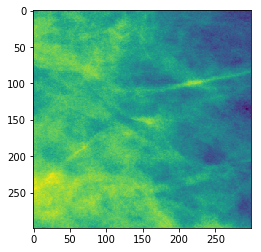

In [92]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    la_b, im_b = sess.run([labels_batch, images_batch])
    
    plt.imshow(im_b[0].reshape([299,299]))
    
    coord.request_stop()
    
    # Wait for threads to stop
    coord.join(threads)
    

In [52]:
for serialized_example in tf.python_io.tf_record_iterator(train_path):
    example = tf.train.Example()
    example.ParseFromString(serialized_example)

    # traverse the Example format to get data
    image = example.features.feature['image'].bytes_list.value
    label = example.features.feature['label'].int64_list.value[0]
    
    break